In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yaml
import torch
from tqdm.notebook import trange



from py2d.initialize import initialize_wavenumbers_rfft2, gridgen, initialize_wavenumbers_fft2
from py2d.convert import *
from py2d.derivative import *

# import the modules
from analysis.metrics import corr_truth_train_model, rmse_truth_train_model
from analysis.return_period import return_period_bins, ensemble_return_period_amplitude, return_period_empirical
from analysis.io_utils import data2density
from analysis.plot_config import params, contourLevels, colormap
# os.environ["PATH"] = f"/home/exouser/karan2/texlive/2025/bin/x86_64-linux:" + os.environ["PATH"] # use path of installed texlive

# plt.rcParams.update(params)

def divergence(u, v, Kx, Ky, spectral=False):
    """
    Calculate the divergence of a 2D velocity field.

    Parameters: 
    ----------
    u, v : numpy.ndarray
        Velocity components in x and y directions.
    Kx, Ky : numpy.ndarray
        Precomputed wavenumbers in the x and y dimensions.
    spectral : bool, optional
        Whether u and v are in the spectral domain. Default is False.   

    Returns:
    -------
    div : numpy.ndarray
        Divergence of the velocity field.
    """
    
    if spectral == False:
        ux = derivative(u, [1, 0], Kx, Ky, spectral=False)
        vy = derivative(v, [0, 1], Kx, Ky, spectral=False)
        div = ux + vy
        return div
    else:
        ux_hat = derivative(u, [1, 0], Kx, Ky, spectral=True)
        vy_hat = derivative(v, [0, 1], Kx, Ky, spectral=True)
        div_hat = ux_hat + vy_hat
        return div_hat

# apply multiple times a function
def apply_multiple_times(func, u, v, n):
    for i in range(n):
        u, v = func(u, v)
    return u, v

# set precision of torch to float16
# torch.set_default_dtype(torch.float16)


# First Test

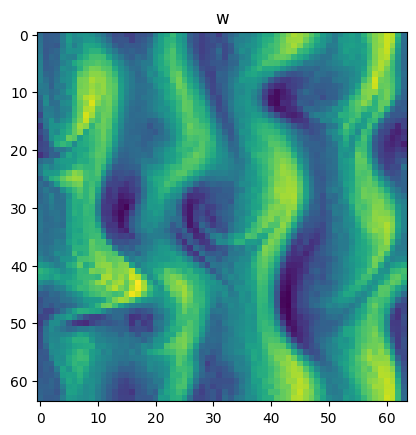

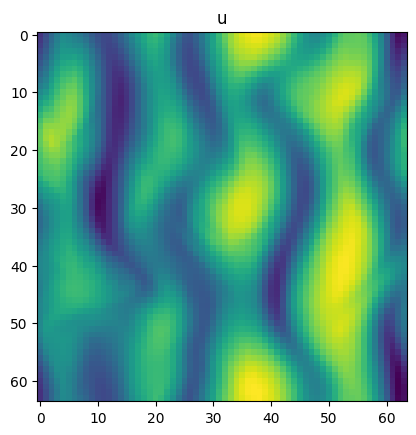

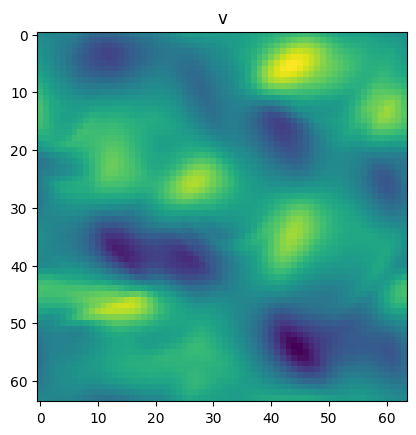

(64, 64)
True


In [327]:
path="/glade/work/kjakhar/data/Re500_fkx4fky4_r0.1_b20/NoSGS/NX64/dt0.0005_IC1/data/"
from scipy.io import loadmat
data = loadmat(path + "5000.mat")

w = np.array(data['Omega'])
nx = w.shape[0]
Lx = 2*np.pi
Kx, Ky, Kabs, Ks, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')
u, v  = Omega2UV(w, Kx, Ky, invKsq, spectral=False)
# see image
plt.title('w')
plt.imshow(w)
plt.show()
plt.title('u')
plt.imshow(u)
plt.show()
plt.title('v')
plt.imshow(v)
plt.show()

# compute divergence of the flow
ux = derivative(u, [1, 0], Kx, Ky, spectral=False)
vy = derivative(v, [0, 1], Kx, Ky, spectral=False)
div = ux + vy
print(div.shape)
# Check if divergence computed from u,v is close to zero (incompressibility)
print(np.allclose(div, 0, atol=1e-13))


In [ ]:
def divergence(u,v, Kx, Ky):
    return derivative(u, [1, 0], Kx, Ky, spectral=False) + derivative(v, [0, 1], Kx, Ky, spectral=False)

In [78]:
divergence(u, v, Kx, Ky)

array([[-1.24344979e-14, -9.76996262e-15,  3.55271368e-15, ...,
        -7.54951657e-15,  8.65973959e-15,  8.88178420e-16],
       [-1.77635684e-15,  1.15463195e-14, -1.11022302e-14, ...,
         2.24265051e-14, -2.26485497e-14,  3.55271368e-15],
       [-1.33226763e-15,  1.46549439e-14,  6.21724894e-15, ...,
        -2.22044605e-15, -1.28785871e-14,  3.06421555e-14],
       ...,
       [-1.50990331e-14, -2.66453526e-14, -9.76996262e-15, ...,
         1.17683641e-14, -3.10307335e-14, -5.88418203e-15],
       [ 2.44249065e-15,  3.30846461e-14,  7.77156117e-15, ...,
        -1.82076576e-14,  4.77395901e-15,  5.10702591e-15],
       [ 3.77475828e-15, -1.36557432e-14, -3.83026943e-15, ...,
         1.13242749e-14, -2.22044605e-16, -9.99200722e-15]],
      shape=(64, 64))

In [70]:
path_yaml = "/glade/work/kjakhar/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4_e800_2500/CDM_s3_Oaw_lrC3e4_e800_2500.yaml"
with open(path_yaml, 'r') as f:
    config = yaml.safe_load(f)

config


{'logging_params': {'log_to_screen': True,
  'diagnostic_logs': False,
  'log_to_wandb': True,
  'wandb_table_logging_interval': 10,
  'wandb_project': 'CDM_step3',
  'wandb_group': 'static',
  'wandb_name': 'CDM_s3_Oaw_lrC3e4_e800_2500'},
 'dataset_params': {'data_dir': '../data/Re500_fkx4fky4_r0.1_b20/NoSGS/NX64/dt0.0005_IC1/',
  'file_range': [400000, 407500],
  'step_size': 3,
  'condition_step_size': 1,
  'num_prev_conditioning_steps': 1,
  'downsample_factor': 1,
  'downsample_procedure': 'spectral',
  'normalize': True},
 'diffusion_params': {'conditional': True,
  'condition_noise': False,
  'num_timesteps': 1000,
  'beta_start': 0.0001,
  'beta_end': 0.02},
 'model_params': {'padding_mode': 'circular',
  'im_channels': 2,
  'pred_channels': 2,
  'cond_channels': 2,
  'coord_conv': False,
  'im_size': 64,
  'down_channels': [32, 64, 128, 256],
  'mid_channels': [256, 256, 128],
  'down_sample': [True, True, False],
  'time_emb_dim': 128,
  'num_down_layers': 2,
  'num_mid_layer

In [71]:
"qqsub -I -l select=1:ngpus=1 -q develop -l walltime=00:30:00 -A URIC0009"


'qqsub -I -l select=1:ngpus=1 -q develop -l walltime=00:30:00 -A URIC0009'

(64, 2, 64, 64)


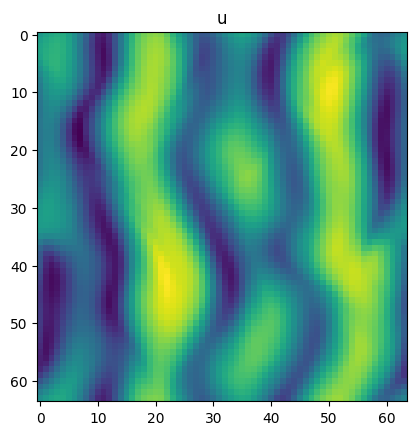

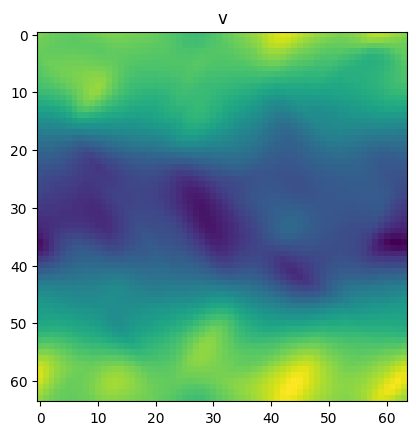

(64, 64)
[[-1.43153884e-01  8.01894885e-02 -1.46664591e-02 ...  2.60409297e-02
   6.64903821e-02 -9.10347303e-02]
 [ 8.38718402e-03 -8.93935655e-03 -1.08186611e-04 ... -7.94313201e-02
   2.92040602e-03  5.92614145e-02]
 [ 5.10635498e-02 -9.29256266e-02  1.63714682e-01 ... -9.67328912e-03
   5.59375554e-02 -1.29230018e-01]
 ...
 [ 1.22477107e-01 -2.62086752e-02  1.07208181e-01 ...  1.69168704e-02
  -4.00874676e-02 -3.45928275e-02]
 [-1.75722804e-02 -7.35046356e-02  5.11112249e-02 ... -3.71548083e-02
  -3.03989948e-02 -1.72039492e-02]
 [ 6.91454016e-03 -5.51427491e-03  2.79738775e-02 ...  4.64167993e-02
  -1.81594981e-01  1.63417252e-01]]
False


In [72]:
path_data_generated ="/glade/work/alancelin/2DTurbDiffusion/results/UDM_s2_Oaw_lrC3e4_e800_2500/data/1_0/6.npy"
data_gen = np.load(path_data_generated)
print(data_gen.shape)

u_gen = data_gen[0, 0, :, :]
v_gen = data_gen[0, 1, :, :]
# plot u, v
plt.title('u')
plt.imshow(u_gen)
plt.show()
plt.title('v')
plt.imshow(v_gen)
plt.show()

# test the divergence
ux_gen = derivative(data_gen[0, 0, :, :], [1, 0], Kx, Ky, spectral=False)
vy_gen = derivative(data_gen[0, 1, :, :], [0, 1], Kx, Ky, spectral=False)
div_gen = ux_gen + vy_gen
print(div_gen.shape)
print(div_gen)
print(np.allclose(div_gen, 0, atol=1e-13))

In [194]:
import numpy as np

def project_div_free_numpy(x, Kx, Ky):
    """
    Project a 2D periodic vector field x (shape (2, Ny, Nx)) onto divergence-free part
    using spectral projection (FFT).
    Returns array of same shape (real).
    """
    assert x.ndim == 3 and x.shape[0] == 2
    u = x[0]
    v = x[1]
    Ny, Nx = u.shape

    # Fourier transforms
    u_hat = np.fft.rfft2(u)
    v_hat = np.fft.rfft2(v)

    # # wave numbers (angular)
    # kx = 2.0 * np.pi * np.fft.fftfreq(Nx)   # length Nx
    # ky = 2.0 * np.pi * np.fft.fftfreq(Ny)   # length Ny
    # kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')  # shape (Ny, Nx)

    k2 = Kx**2 + Ky**2
    # avoid division by zero at k=0
    k2_nozero = k2.copy()
    k2_nozero[k2_nozero == 0] = 1.0

    # dot product k·u_hat in Fourier space
    kup =  (Kx * u_hat + Ky * v_hat)   # broadcasting complex * real -> complex

    # projection: u_hat_perp = u_hat - k * (k·u_hat) / k2
    u_hat_perp = u_hat - (Kx * kup) / k2_nozero
    v_hat_perp = v_hat - (Ky * kup) / k2_nozero

    # optionally set mean / zero mode: here we keep it (could set to zero if you want)
    # inverse transform back to real space
    u_perp = np.fft.irfft2(u_hat_perp, s=[Nx, Ny])
    v_perp = np.fft.irfft2(v_hat_perp, s=[Nx, Ny])
    return np.stack([u_perp, v_perp], axis=0)

In [125]:
# make a random field and project, then check divergence ≈ 0
Ny = Nx = 64
x = np.random.randn(2, Ny, Nx)
np.random.seed(1)

xf = project_div_free_numpy(np.stack([u_gen, v_gen]), Kx, Ky)
xf = x.copy()
for _ in range(100):  # apply 3 times
    xf = project_div_free_numpy(xf, Kx, Ky)


# compute spectral divergence of projected field (should be near zero)
div = derivative(xf[0], [1, 0], Kx, Ky, spectral=False) + derivative(xf[1], [0, 1], Kx, Ky, spectral=False)
print("max abs(div) =", np.abs(div).max())
div

max abs(div) = 0.09828560594871405


array([[-0.05916246,  0.05916246, -0.05916246, ...,  0.05916246,
        -0.05916246,  0.05916246],
       [-0.07114898,  0.07114898, -0.07114898, ...,  0.07114898,
        -0.07114898,  0.07114898],
       [-0.07906455,  0.07906455, -0.07906455, ...,  0.07906455,
        -0.07906455,  0.07906455],
       ...,
       [-0.01066041,  0.01066041, -0.01066041, ...,  0.01066041,
        -0.01066041,  0.01066041],
       [-0.02850315,  0.02850315, -0.02850315, ...,  0.02850315,
        -0.02850315,  0.02850315],
       [-0.04468985,  0.04468985, -0.04468985, ...,  0.04468985,
        -0.04468985,  0.04468985]], shape=(64, 64))

In [197]:
# building projection operator of the divergence operator
def derivative(T, order, Kx, Ky, spectral=False):
    """
    Calculate spatial derivatives for 2D_FHIT in spectral space.
    Boundary conditions are periodic in x and y spatial dimensions

    Parameters:
    ----------
    T : numpy.ndarray
        Input flow field. If `spectral` is False, T is in the physical domain; otherwise, it is in the spectral domain.
    order : list
        Array of order of derivatives in x and y spatial dimensions. Expects a list of two integers >=0.
    Kx, Ky : numpy.ndarray
        Precomputed wavenumbers in the x and y dimensions.
    spectral : bool, optional
        Whether T is in the spectral domain. Default is False.

    Returns:
    -------
    Tderivative or Tderivative_hat : numpy.ndarray
        The derivative of the flow field T. If `spectral` is False, this is in the physical domain; otherwise, it's in the spectral domain.
    """

    # If the input data is not in the spectral domain, we transform it
    if spectral == False:
        Tderivative = derivative_physical(T, order, Kx, Ky)
        return Tderivative
    else:  # if it is already in the spectral domain, we do nothing
        T_hat = T
        Tderivative_hat = derivative_spectral(T_hat, order, Kx, Ky)
        return Tderivative_hat

def derivative_physical(T, order, Kx, Ky, ):
    """
    Calculate spatial derivatives for 2D_FHIT in physical space using spectral methods.
    Boundary conditions are periodic in x and y spatial dimensions

    Parameters:
    ----------
    T : numpy.ndarray
        Input flow field. T is in the physical domain.
    order : list
        Array of order of derivatives in x and y spatial dimensions. Expects a list of two integers >=0.
    Kx, Ky : numpy.ndarray
        Precomputed wavenumbers in the x and y dimensions.

    Returns:
    -------
    Tderivative : numpy.ndarray
        The derivative of the flow field T in the physical domain.
    """
    Nx, Ny = T.shape
    # We transform data to spectral domain
    T_hat = np.fft.rfft2(T)
    # Orders of derivatives in x and y dimensions
    Tderivative_hat = derivative_spectral(T_hat, order, Kx, Ky)
    # Transform the result back into the physical domain
    Tderivative = np.fft.irfft2(Tderivative_hat, s=[Nx, Ny])
    return Tderivative

def derivative_spectral(T_hat, order, Kx, Ky):
    """
    Calculate spatial derivatives for 2D_FHIT in spectral space.
    Boundary conditions are periodic in x and y spatial dimensions

    Parameters:
    ----------
    T_hat : numpy.ndarray
        Input flow field. T_hat is in the spectral domain.
    order : list
        Array of order of derivatives in x and y spatial dimensions. Expects a list of two integers >=0.
    Kx, Ky : numpy.ndarray
        Precomputed wavenumbers in the x and y dimensions.

    Returns:
    -------
    Tderivative_hat : numpy.ndarray
        The derivative of the flow field T_hat in the spectral domain.
    """

    # Orders of derivatives in x and y dimensions
    orderX = order[0]
    orderY = order[1]

    # Calculating derivatives in spectral space using the Fourier derivative theorem
    Tderivative_hat = ((1j*Kx)**orderX) * ((1j*Ky)**orderY) * T_hat

    return Tderivative_hat


def divergence(u, v, Kx, Ky, spectral=False):
    """
    Calculate the divergence of a 2D velocity field.

    Parameters: 
    ----------
    u, v : numpy.ndarray
        Velocity components in x and y directions.
    Kx, Ky : numpy.ndarray
        Precomputed wavenumbers in the x and y dimensions.
    spectral : bool, optional
        Whether u and v are in the spectral domain. Default is False.   

    Returns:
    -------
    div : numpy.ndarray
        Divergence of the velocity field.
    """
    
    if spectral == False:
        ux = derivative(u, [1, 0], Kx, Ky, spectral=False)
        vy = derivative(v, [0, 1], Kx, Ky, spectral=False)
        div = ux + vy
        return div
    else:
        ux_hat = derivative(u, [1, 0], Kx, Ky, spectral=True)
        vy_hat = derivative(v, [0, 1], Kx, Ky, spectral=True)
        div_hat = ux_hat + vy_hat
        return div_hat




# div_gen = np.array(list(map(lambda i: divergence(data_gen[i, 0, :, :], data_gen[i, 1, :, :], Kx, Ky, spectral=False), range(data_gen.shape[0]))))
div_gen = divergence(data_gen[0, 0, :, :], data_gen[0, 1, :, :], Kx, Ky, spectral=False)
print(div_gen.shape)
print(div_gen)
print(np.allclose(div_gen, 0, atol=1e-13))


NameError: name 'data_gen' is not defined

# Early test with projection operator

In [44]:
import torch

# set random seed
torch.manual_seed(1)
Nx, Ny = 64, 64

# draw a random field of shape (2, Ny, Nx)
x = torch.randn(2, Ny, Nx)
x_flat = x.reshape(-1)
print(x_flat.shape)
d = x_flat.shape[0]
print(d)

# define a tensor that maps input x to output in shape (Nx, Ny)
A = torch.randn(d//2, d)
print(torch.mean(torch.abs(A @ x_flat)).item())

# define projection operator
P = torch.eye(d) - A.T @ torch.linalg.inv(A @ A.T) @ A
print(torch.mean(torch.abs(A @ (P @ x_flat))).item())

torch.Size([8192])
8192
73.93021392822266
8.024097041925415e-05


In [46]:
A.shape

torch.Size([4096, 8192])

In [ ]:
x = torch.randn(2, Ny, Nx)
x_flat = x.reshape(-1)
print(torch.mean(torch.abs(A @ @ x_flat))).item())

1.6173109543160535e-05


In [190]:
A.shape

(288, 288)

In [329]:
import numpy as np

def leray_projection(u, v):
    """
    Effectue la projection de Leray d'un champ de vecteurs 2D périodique.
    
    Paramètres:
    u, v : ndarray
        Composantes du champ de vecteurs (NxN)
    
    Retourne:
    u_proj, v_proj : ndarray
        Composantes projetées (divergence nulle)
    """
    N = u.shape[0]
    kx = np.fft.fftfreq(N) * 2 * np.pi
    ky = np.fft.fftfreq(N) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    # Transformée de Fourier
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    
    # Norme au carré du vecteur d'onde
    k2 = kx**2 + ky**2
    k2[0,0] = 1  # éviter la division par zéro
    
    # Projection de Leray : P_ij = delta_ij - k_i k_j / |k|^2
    u_hat_proj = u_hat - (kx*(kx*u_hat + ky*v_hat)) / k2
    v_hat_proj = v_hat - (ky*(kx*u_hat + ky*v_hat)) / k2
    
    # Transformée inverse
    u_proj = np.fft.ifft2(u_hat_proj).real
    v_proj = np.fft.ifft2(v_hat_proj).real
    
    return u_proj, v_proj

# Exemple d'utilisation
N = 64
u = np.random.randn(N, N)
v = np.random.randn(N, N)
print("Mean divergence before projection:", np.mean(np.abs(divergence2(u, v))))

u_proj, v_proj = leray_projection(u, v)

# Vérification : divergence proche de zéro
# np.random.seed(3)
def divergence2(u, v):
    N = u.shape[0]
    kx = np.fft.fftfreq(N, 2*np.pi/N) * 2 * np.pi
    ky = np.fft.fftfreq(N, 2*np.pi/N) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    
    div_hat = 1j * (kx * u_hat + ky * v_hat)
    div = np.fft.ifft2(div_hat).real
    return div

div = divergence(u_proj, v_proj, Kx, Ky, spectral=False)
div2 = divergence2(u_proj, v_proj)
# print("Mean divergence after projection:", np.mean(np.abs(div2)))
print("Mean divergence after projection:", np.mean(np.abs(div)))
print("Mean divergence after projection:", np.mean(np.abs(div2)))

ValueError: operands could not be broadcast together with shapes (64,64) (64,33) 

In [ ]:
import numpy as np

def leray_projection(u, v):
    N = u.shape[0]
    kx = np.fft.fftfreq(N, 1.0/N) * 2 * np.pi
    ky = np.fft.fftfreq(N, 1.0/N) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')

    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    
    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0
    
    u_hat_proj = u_hat - (kx * (kx*u_hat + ky*v_hat)) / k2
    v_hat_proj = v_hat - (ky * (kx*u_hat + ky*v_hat)) / k2
    
    u_proj = np.fft.ifft2(u_hat_proj).real
    v_proj = np.fft.ifft2(v_hat_proj).real
    return u_proj, v_proj

def divergence3(u, v):
    N = u.shape[0]
    kx = np.fft.fftfreq(N, 1.0/N) * 2 * np.pi
    ky = np.fft.fftfreq(N, 1.0/N) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    div_hat = 1j * (kx*u_hat + ky*v_hat)
    div = np.fft.ifft2(div_hat).real
    return div

def divergence2(u, v):
    N = u.shape[0]
    kx = np.fft.fftfreq(N) * 2 * np.pi
    ky = np.fft.fftfreq(N) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    
    div_hat = 1j * (kx * u_hat + ky * v_hat)
    div = np.fft.ifft2(div_hat).real
    return div

N = 64
u = np.random.randn(N, N)
v = np.random.randn(N, N)

div_before = divergence2(u, v)
u_proj, v_proj = leray_projection(u, v)
div_after = divergence2(u_proj, v_proj)

print("Mean divergence before:", np.mean(np.abs(div_before)))
print("Mean divergence after:", np.mean(np.abs(div_after)))

Mean divergence before: 129.76937578274567
Mean divergence after: 10.806244666381895


In [306]:
N = 64
u = np.random.randn(N, N)
v = np.random.randn(N, N)

div_before = divergence2(u, v)
print("Mean divergence before:", np.mean(np.abs(div_before)))


N = 64
u = np.random.randn(N, N)
v = np.random.randn(N, N)
print("Mean divergence before projection:", np.mean(np.abs(divergence2(u, v))))

Mean divergence before: 2.0242677985532596
Mean divergence before projection: 1.9669805185158604


In [322]:
nx, ny = 64, 64
Lx, Ly = 2*np.pi, 2*np.pi


# Create an array of the discrete Fourier Transform sample frequencies in x-direction
kx = 2 * np.pi * np.fft.fftfreq(nx, d=Lx/nx)

# Create an array of the discrete Fourier Transform sample frequencies in y-direction
ky = 2 * np.pi * np.fft.fftfreq(ny, d=Ly/ny)

# Return coordinate grids (2D arrays) for the x and y wavenumbers
(Kx, Ky) = np.meshgrid(kx, ky, indexing='ij')
Kx

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ...,
       [-3., -3., -3., ..., -3., -3., -3.],
       [-2., -2., -2., ..., -2., -2., -2.],
       [-1., -1., -1., ..., -1., -1., -1.]], shape=(64, 64))

In [324]:
N = u.shape[0]
kx = np.fft.fftfreq(N) * 2 * np.pi
ky = np.fft.fftfreq(N) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky, indexing='ij')
kx

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09817477,  0.09817477,  0.09817477, ...,  0.09817477,
         0.09817477,  0.09817477],
       [ 0.19634954,  0.19634954,  0.19634954, ...,  0.19634954,
         0.19634954,  0.19634954],
       ...,
       [-0.29452431, -0.29452431, -0.29452431, ..., -0.29452431,
        -0.29452431, -0.29452431],
       [-0.19634954, -0.19634954, -0.19634954, ..., -0.19634954,
        -0.19634954, -0.19634954],
       [-0.09817477, -0.09817477, -0.09817477, ..., -0.09817477,
        -0.09817477, -0.09817477]], shape=(64, 64))

# New test

In [479]:
path="/glade/work/kjakhar/data/Re500_fkx4fky4_r0.1_b20/NoSGS/NX64/dt0.0005_IC1/data/"
from scipy.io import loadmat
data = loadmat(path + "5000.mat")

w = np.array(data['Omega'])
nx = w.shape[0]
Lx = 2*np.pi
Kx, Ky, Kabs, Ks, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')
u, v  = Omega2UV(w, Kx, Ky, invKsq, spectral=False)


# compute divergence of the flow
div = divergence(u, v, Kx, Ky, spectral=False)
# Check if divergence computed from u,v is close to zero (incompressibility)
print(np.mean(np.abs(div)))
print(np.allclose(div, 0, atol=1e-13))

9.968051435812163e-15
True


In [480]:
Kx

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ...,
       [-3., -3., -3., ..., -3., -3., -3.],
       [-2., -2., -2., ..., -2., -2., -2.],
       [-1., -1., -1., ..., -1., -1., -1.]], shape=(64, 33))

In [ ]:
def divergence_2(u, v):
    N = u.shape[0]
    kx = np.fft.fftfreq(N, 1./N)
    ky = np.fft.fftfreq(N, 1./N) 
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    div_hat = 1j * (kx*u_hat + ky*v_hat)
    div = np.fft.ifft2(div_hat).real
    return div

div2 = divergence_2(u, v)
print(np.mean(np.abs(div2)))

(64, 64)
9.125669750584669e-15


In [503]:
import numpy as np
from py2d.util import fft2_to_rfft2

def leray_projection(u, v):
    N = u.shape[0]
    # Domain is [0, 2π], so wavenumbers are integers (0, ±1, ±2, …)
    kx = np.fft.fftfreq(N, d=1./N)  # frequencies in cycles per 2π
    ky = np.fft.fftfreq(N, d=1./N)
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    # kx, ky = fft2_to_rfft2(kx), fft2_to_rfft2(ky)

    # Fourier transform
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)

    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0  # avoid division by zero

    # Leray projection: P = I - k k^T / |k|^2
    u_hat_proj = u_hat - (kx * (kx*u_hat + ky*v_hat)) / k2
    v_hat_proj = v_hat - (ky * (kx*u_hat + ky*v_hat)) / k2
    # print("k.hat(u)_proj =", np.mean(np.abs(kx*u_hat_proj + ky*v_hat_proj)))

    # Back to the physical domain
    # u_proj = np.fft.ifft2(u_hat_proj).real
    # v_proj = np.fft.ifft2(v_hat_proj).real
    u_proj = np.fft.ifft2(u_hat_proj).real
    v_proj = np.fft.ifft2(v_hat_proj).real

    return u_proj, v_proj


# === Test ===
N = 64
u = np.random.randn(N, N) 
v = np.random.randn(N, N)
np.random.seed(0)

div_before2 = divergence_2(u, v)
div_before = divergence(u, v, Kx, Ky, spectral=False)


u_proj, v_proj = leray_projection(u, v)
u_proj_twice, v_proj_twice = apply_multiple_times(leray_projection, u, v, 100)


div_after2 = divergence_2(u_proj, v_proj)
div_after = divergence(u_proj, v_proj, Kx, Ky, spectral=False)
div_after_twice = divergence(u_proj_twice, v_proj_twice, Kx, Ky, spectral=False)
div_after_twice2 = divergence_2(u_proj_twice, v_proj_twice)

print()
print("Mean divergence before:", np.mean(np.abs(div_before)))
print("Mean divergence 2 before:", np.mean(np.abs(div_before2)))
print()
print("Mean divergence after:", np.mean(np.abs(div_after)))
print("Mean divergence 2 after:", np.mean(np.abs(div_after2)))

print("Mean divergence after twice:", np.mean(np.abs(div_after_twice)))
print("Mean divergence 2 after twice:", np.mean(np.abs(div_after_twice2)))

(64, 64)
(64, 64)
(64, 64)

Mean divergence before: 20.07074781314799
Mean divergence 2 before: 19.84936371382027

Mean divergence after: 1.8325923206094616
Mean divergence 2 after: 1.738320746211631
Mean divergence after twice: 0.0609459225187899
Mean divergence 2 after twice: 0.06094592251879


In [ ]:
path_data_generated ="/glade/work/alancelin/2DTurbDiffusion/results/UDM_s2_Oaw_lrC3e4_e800_2500/data/1_0/6.npy"
data_gen = np.load(path_data_generated)
print(data_gen.shape)

u_gen = data_gen[0, 0, :, :]
v_gen = data_gen[0, 1, :, :]

div_before2 = divergence_2(u_gen, v_gen)
div_before = divergence(u_gen, v_gen, Kx, Ky, spectral=False)
u_proj, v_proj = leray_projection(u_gen, v_gen)
div_after2 = divergence_2(u_proj, v_proj)
div_after = divergence(u_proj, v_proj, Kx, Ky, spectral=False)

print("Mean divergence before:", np.mean(np.abs(div_before)))
print("Mean divergence 2 before:", np.mean(np.abs(div_before2)))
print()
print("Mean divergence after:", np.mean(np.abs(div_after)))
print("Mean divergence 2 after:", np.mean(np.abs(div_after2)))

# Test exact projection

In [2]:
def flatten_operator(u, v=None):
    if v is None:
        return u.flatten()
    else:
        return np.concatenate([u.flatten(), v.flatten()])

def unflatten_operator(x, Nx, Ny):
    # u is a vector of size 2*Nx*Ny
    return np.reshape(x[:Nx*Ny], (Nx, Ny)), np.reshape(x[Nx*Ny:], (Nx, Ny))

def test_flatten_operator(tol=1e-10):
    u_start, v_start = np.random.randn(64, 64), np.random.randn(64, 64)
    print(flatten_operator(u_start, v_start).shape)
    u_end, v_end = unflatten_operator(flatten_operator(u_start, v_start), 64, 64)
    print(u_end.shape, v_end.shape)
    # check that u_start and v_start are close to u_end and v_end
    diff = np.max(np.abs(u_start - u_end))
    print(f"Difference: {diff}")
    if diff < tol:
        print("Test passed")
    else:
        print("Test failed")
    return diff

def divergence_operator(x, Nx=None, Ny=None):
    if Nx is None:
        Nx = int(np.sqrt(x.shape[0]//2))
    if Ny is None:
        Ny = int(np.sqrt(x.shape[0]//2))
    N = Nx
    # print(N)
    u, v = unflatten_operator(x, Nx, Ny)
    kx = np.fft.fftfreq(Nx, 1./Nx)
    ky = np.fft.fftfreq(Ny, 1./Ny) 
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    div_hat = 1j * (kx*u_hat + ky*v_hat)
    div = np.fft.ifft2(div_hat).real
    return flatten_operator(div)

In [3]:
Nx, Ny = 64, 64
u_gen = np.random.randn(Nx, Ny)
v_gen = np.random.randn(Nx, Ny)

x_gen = flatten_operator(u_gen, v_gen)
div_gen = divergence_operator(x_gen)
print(div_gen.shape)
np.mean(np.abs(div_gen))

(4096,)


np.float64(20.469594463335255)

In [31]:
import torch

# ---------------------------
# Flatten / Unflatten
# ---------------------------
def flatten_operator(u, v=None):
    # u, v: (Nx, Ny)
    if v is None:
        return u.flatten()
    else:
        return torch.cat([u.flatten(), v.flatten()])


def unflatten_operator(x, Nx, Ny):
    u = x[:Nx*Ny].reshape(Nx, Ny)
    v = x[Nx*Ny:].reshape(Nx, Ny)
    return u, v

# ---------------------------
# Test function
# ---------------------------
def test_flatten_operator(tol=1e-10):
    Nx, Ny = 64, 64
    u_start = torch.randn(Nx, Ny)
    v_start = torch.randn(Nx, Ny)
    print(flatten_operator(u_start, v_start).shape)
    u_end, v_end = unflatten_operator(flatten_operator(u_start, v_start), Nx, Ny)
    print(u_end.shape, v_end.shape)
    diff = torch.max(torch.abs(u_start - u_end))
    print(f"Difference: {diff.item()}")
    if diff < tol:
        print("Test passed")
    else:
        print("Test failed")
    return diff

# ---------------------------
# Divergence operator
# ---------------------------
def divergence_operator(x, Nx=None, Ny=None):
    if Nx is None:
        Nx = int((x.shape[0] // 2) ** 0.5)
    if Ny is None:
        Ny = int((x.shape[0] // 2) ** 0.5)

    u, v = unflatten_operator(x, Nx, Ny)

    # FFT frequencies
    kx = torch.fft.fftfreq(Nx, 1.0 / Nx)
    ky = torch.fft.fftfreq(Ny, 1.0 / Ny)
    kx, ky = torch.meshgrid(kx, ky, indexing='ij')

    # 2D FFT
    u_hat = torch.fft.fft2(u)
    v_hat = torch.fft.fft2(v)

    # Divergence in Fourier space
    div_hat = 1j * (kx * u_hat + ky * v_hat)

    # Inverse FFT and take real part
    div = torch.fft.ifft2(div_hat).real
    return flatten_operator(div)



def projection_operator(Nx, Ny):
    np.random.seed(0)
    x = torch.randn(Nx*Ny*2)
    J = torch.autograd.functional.jacobian(divergence_operator, x) 
    return torch.eye(Nx*Ny*2) - J.T@torch.linalg.inv(J@J.T+1e-12*torch.eye(4096, 4096))@J

def projection_operator_optimized(Nx, Ny):
    np.random.seed(0)
    x = torch.randn(Nx*Ny*2)
    J = torch.autograd.functional.jacobian(divergence_operator, x) 
    X=  torch.linalg.lstsq(J@J.T, J)[0]
    return torch.eye(Nx*Ny*2) - J.T@X

def leray_projection(u, v):
    """
    u, v: tensors of shape (N, N), dtype=torch.float32 or torch.float64
    Returns u_proj, v_proj of the same shape after Leray projection.
    """
    N = u.shape[0]

    # Fourier frequencies
    kx = torch.fft.fftfreq(N, d=1./N, device=u.device)  # shape (N,)
    ky = torch.fft.fftfreq(N, d=1./N, device=u.device)  # shape (N,)
    kx, ky = torch.meshgrid(kx, ky, indexing='ij')      # shape (N, N)

    # Fourier transform
    u_hat = torch.fft.fft2(u)
    v_hat = torch.fft.fft2(v)

    # Square of wave numbers
    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0  # avoid division by zero

    # Leray projection: P = I - k k^T / |k|^2
    k_dot_u = kx * u_hat + ky * v_hat
    u_hat_proj = u_hat - (kx * k_dot_u) / k2
    v_hat_proj = v_hat - (ky * k_dot_u) / k2

    # Back to physical space
    u_proj = torch.fft.ifft2(u_hat_proj).real
    v_proj = torch.fft.ifft2(v_hat_proj).real

    return u_proj, v_proj

# ---------------------------
# Example usage
# ---------------------------
diff = test_flatten_operator()
print("Divergence example:")
Nx, Ny = 64, 64
u_gen = torch.randn(Nx, Ny)
v_gen = torch.randn(Nx, Ny)
x = flatten_operator(u_gen, v_gen)
div = divergence_operator(x)
print(div.shape)
print(torch.mean(torch.abs(div)))


torch.Size([8192])
torch.Size([64, 64]) torch.Size([64, 64])
Difference: 0.0
Test passed
Divergence example:
torch.Size([4096])
tensor(20.5625)


In [32]:
# Test the sensitivity of the divergence operator to the input

# Compute Jacobian
x0 = torch.randn(64*64*2)
print(x0.shape)
x1 = torch.randn(64*64*2)
Jx0 = torch.autograd.functional.jacobian(divergence_operator, x0)
print(Jx0.shape)
Jx1 = torch.autograd.functional.jacobian(divergence_operator, x1)

# print the max of the absolute value of the Jacobian
print(torch.max(torch.abs(Jx0 - Jx1)))
J = Jx0

# test that J@x = div(x)
print(torch.max(torch.abs(Jx0@x0 - divergence_operator(x0))))
print(torch.max(torch.abs(Jx1@x1 - divergence_operator(x1))))

torch.Size([8192])


torch.Size([4096, 8192])
tensor(0.)
tensor(3.0518e-05)
tensor(2.6703e-05)


In [33]:
proj = projection_operator_optimized(64, 64)
x = torch.randn(64*64*2)
J = torch.autograd.functional.jacobian(divergence_operator, x)

In [56]:
x = torch.randn(64*64*2)
u, v = unflatten_operator(x, 64, 64)


n_apply = 1
print(torch.mean(torch.abs(divergence_operator(torch.linalg.matrix_power(proj, n_apply) @ x))))
print(torch.mean(torch.abs(J@(torch.linalg.matrix_power(proj, n_apply) @ x))))
u_proj, v_proj = apply_multiple_times(leray_projection, u, v, n_apply)
print(torch.mean(torch.abs(divergence_operator(flatten_operator(u_proj, v_proj)))))

tensor(8.8772e-05)
tensor(8.8733e-05)
tensor(1.6108)


  0%|          | 0/99 [00:00<?, ?it/s]

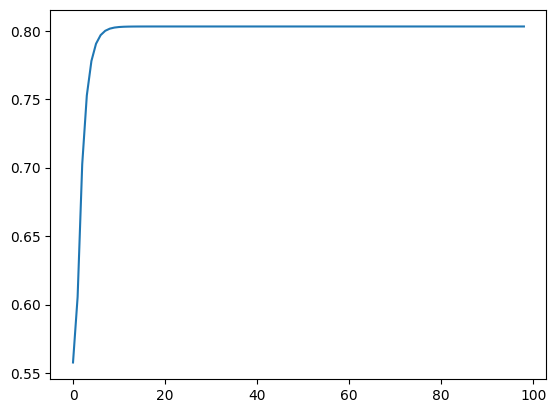

In [35]:
errors =[]
for n_apply in trange(1, 100):
    value = torch.mean(torch.abs(proj**n_apply @ x -  x))
    errors.append(value)
plt.plot(errors)
